In [17]:
import os
import cv2
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [18]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [19]:
config = {}

config['path_to_data'] = data_path+"ids/cut/"
config['path_to_data'] = data_path+"ids/images/"

config['path_to_outdata'] = data_path+"ids/data/"

config['date1'] = "2024-03-08"
# config['date2'] = "2024-03-09"

config['nth'] = 1


In [20]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):

    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

    return g.ravel()

  0%|          | 0/3 [00:00<?, ?it/s]

20240308_160004.png


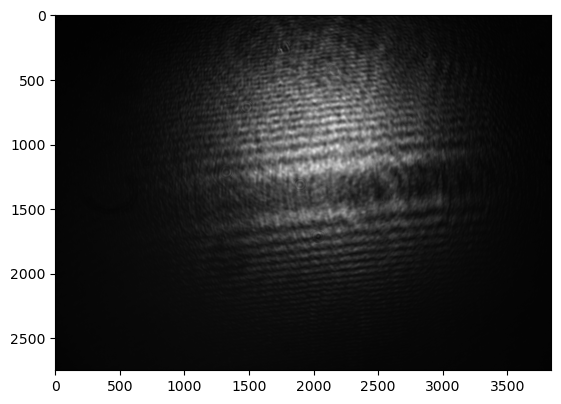

20240308_162304.png


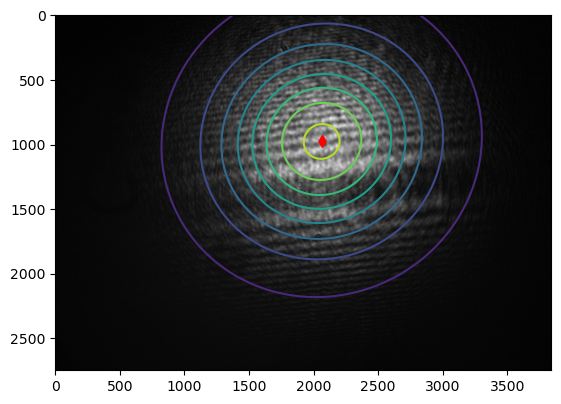

20240308_221504.png


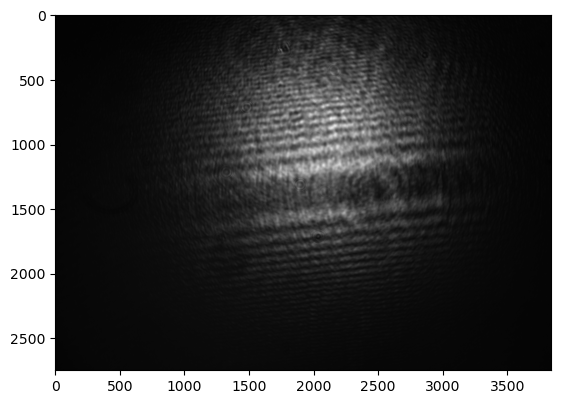

In [23]:

for _date in date_range(config['date1'], config['date1']):

    ## get date as str
    date_str = str(_date)[:10]

    path_to_data = f"{config['path_to_data']}{date_str.replace('-','')}/"

    ## read files in directory
    files = os.listdir(path_to_data)

    ## dummy data
    dummy = np.ones(len(files))*np.nan

    ## prepare output dataframe
    df_out = DataFrame()

    for col in ["time", "x", "y", "x_idx", "y_idx", "amp", "x_sig", "y_sig", "theta", "offset", "x_var", "y_var", "amp_var", "y_sig_var", "x_sig_var", "theta_var", "offset_var"]:
        df_out[col] = dummy


    for _n, file in enumerate(tqdm(files[:3])):
    # for _n, file in enumerate(tqdm(files[::config['nth']])):

        print(file)

        ## check data type
        if file[-3:] != "png":
            print(f" -> not a png: {file}")
            continue

        ## load image and get dimensions
        try:
            im = cv2.imread(path_to_data+file, -1)
            h, w = im.shape
            data = im.ravel()

        except:
            print(f" -> failed to load image: {file}")
            continue

        cmap = plt.get_cmap("gray")
        plt.imshow(im, cmap=cmap)
        plt.show();

        ## prepare x-y-mesh
        x = np.linspace(0, w, w)
        y = np.linspace(0, h, h)
        x, y = np.meshgrid(x, y)

        # initial guess of parameters [ amplitude, xo, yo, sigma_x, sigma_y, theta, offset ]
        initial_guess = (255, 2000, 1000, 500, 500, 0, 0)

        try:

            # find the optimal Gaussian parameters
            popt, pcov = curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess)

            # create new data with these parameters
            data_fitted = twoD_Gaussian((x, y), *popt)

        except:
            continue

        ## get diagonal values
        pcov_diag = np.diag(pcov)

        # reshape to image dimensions
        im_fitted = data_fitted.reshape(h, w)

        ## get maximum of 2d fit
        y_max, x_max = np.argwhere(im_fitted == im_fitted.max())[0]

        _date_str = file.split('.')[0].split('_')[0]
        _time_str = file.split('.')[0].split('_')[1]

        df_out.loc[_n, 'time'] = str(UTCDateTime(_date_str+"T"+_time_str))

        df_out.loc[_n, 'y_idx'] = y_max
        df_out.loc[_n, 'x_idx'] = x_max

        df_out.loc[_n, 'amp'] = popt[0]
        df_out.loc[_n, 'x'] = popt[1]
        df_out.loc[_n, 'y'] = popt[2]
        df_out.loc[_n, 'x_sig'] = popt[3]
        df_out.loc[_n, 'y_sig'] = popt[4]
        df_out.loc[_n, 'theta'] = popt[5]
        df_out.loc[_n, 'offset'] = popt[6]

        df_out.loc[_n, 'amp_var'] = pcov_diag[0]
        df_out.loc[_n, 'x_var'] = pcov_diag[1]
        df_out.loc[_n, 'y_var'] = pcov_diag[2]
        df_out.loc[_n, 'x_sig_var'] = pcov_diag[3]
        df_out.loc[_n, 'y_sig_var'] = pcov_diag[4]
        df_out.loc[_n, 'theta_var'] = pcov_diag[5]
        df_out.loc[_n, 'offset_var'] = pcov_diag[6]


        if _n % 10 == 0:

            fig = plt.figure();

            plt.imshow(im, cmap=plt.get_cmap("gray"));
            plt.contour(x, y, im_fitted);
            plt.scatter(x_max, y_max, color="red", marker="d");

            fig.savefig(config['path_to_outdata']+"outfigs/"+f"{file[:-4]}_mod.png", format="png", dpi=150, bbox_inches='tight');

        _gc = gc.collect();


    ## sort for time column
    df_out.sort_values(by="time", inplace=True)

    ## write output data frame
    df_out.to_pickle(config['path_to_outdata']+f"{date_str}.pkl")


# cv2.imwrite(r"path_to_save\data_fitted.png", data_fitted.reshape(h,w))

In [ ]:
cmap = plt.get_cmap("gray")

y_max, x_max = np.argwhere(im_fitted == im_fitted.max())[0]

plt.imshow(im, cmap=cmap)
plt.contour(x, y, im_fitted)
plt.scatter(x_max, y_max, color="red", marker="d")

plt.show();


In [24]:
df_out

,time,x,y,x_idx,y_idx,amp,x_sig,y_sig,theta,offset,x_var,y_var,amp_var,y_sig_var,x_sig_var,theta_var,offset_var
0,2024-03-08T16:00:04.000000Z,2062.399500,975.837988,2062.0,975.0,115.070372,512.898287,489.504444,0.455192,9.116777,0.005015,0.004865,0.000261,0.006138,0.006601,0.000005,0.000020
1,2024-03-08T16:23:04.000000Z,2062.599003,973.485424,2062.0,973.0,115.384323,512.717663,489.229673,0.452232,9.177579,0.004995,0.004843,0.000262,0.006110,0.006569,0.000005,0.000020
2,2024-03-08T22:15:04.000000Z,2064.426073,971.791562,2064.0,971.0,118.216585,512.519862,488.678917,0.443243,9.266583,0.004986,0.004824,0.000275,0.006089,0.006550,0.000004,0.000021
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

print(popt)
print(np.diag(pcov))
plt.imshow(pcov)

In [26]:
config['path_to_outdata']+f"{date_str}.pkl"

'/home/andbro/kilauea-data/ids/data/20240308.pkl'